# Volume-matching workflow for GR-GR intersections

In this notebook, we detail the algorithm for getting the intersections of the ground radar beams.

Import libraries.

In [1]:
import wradlib as wrl
import numpy as np
import matplotlib.pyplot as pl
import pickle
import os
from scipy import spatial

Set the parameters for the radars.

* `tilts` are the elevation angles of the radars in degrees

* `ntilt` is the number of elevation angles considered

* `nrays` is the number of azimuth angles

* `nbins` is the number of bins in one radial

* `rscale` is the radial resolution of the radar in meters

* `sitecoords` is the coordinates of the radar in (lon,lat,alt)

SUBIC radar:

In [2]:
# let's try for the first 7 elevation angles
tilts1 = np.array([0.5, 1.5, 2.4, 3.4, 4.3, 5.3, 6.2])
ntilt1 = len(tilts1)
nrays1 = 360
nbins1 = 240
rscale1 = 500.
sitecoords1 = (120.364, 14.822, 532)          # (lon, lat, alt)

sph1 = np.empty((ntilt1, nrays1, nbins1, 3))
for i in range(ntilt1):
    elangle = tilts1[i]
    sph1[i, ...] = wrl.georef.sweep_centroids(nrays1, rscale1, nbins1, elangle)


TAGAYTAY radar:

In [3]:
tilts2 = np.array([0.5, 1.5, 2.4, 3.4, 4.3, 5.3, 6.2])
ntilt2 = len(tilts2)
nrays2 = 360
nbins2 = 240
rscale2 = 500.
sph2 = np.empty((ntilt2, nrays2, nbins2, 3))
for i in range(ntilt2):
    elangle = tilts2[i]
    sph2[i, ...] = wrl.georef.sweep_centroids(nrays2, rscale2, nbins2, elangle)
sitecoords2 = (121.02, 14.14, 752)          # (lon, lat, alt)

Transform the spherical coordinates of the radars into azimuthal equidistant projection centered on each radar.

In [4]:
# Radar 1 in azeq1
xyz1to1, proj1 = wrl.georef.spherical_to_xyz(sph1[..., 0], np.degrees(sph1[..., 1]),
                                                 sph1[..., 2], sitecoords1)

# Radar 2 in azeq2
xyz2to2, proj2 = wrl.georef.spherical_to_xyz(sph2[..., 0], np.degrees(sph2[..., 1]),
                                                 sph2[..., 2], sitecoords2)

Notes:

`sph2[...,0]` = distance from radar station (m)

`sph2[...,1]` = azimuth angle (degrees)

`sph2[...,2]` = elevation angle (degrees)

In [5]:
xyz1to1.shape

(7, 360, 240, 3)

Transform each radar into the other radar's azimuthal equidistance projection.

In [6]:
# Radar 2 in azeq1
xyz_2to1 = wrl.georef.spherical_to_proj(sph2[..., 0],np.degrees(sph2[..., 1]),
                                               sph2[..., 2], sitecoords2, proj=proj1)

# Radar 1 in azeq2
xyz_1to2 = wrl.georef.spherical_to_proj(sph1[..., 0],np.degrees(sph1[..., 1]),
                                               sph1[..., 2], sitecoords1, proj=proj2)

Reproject each coordinate into spherical coordinates again, to compute the region of overlap.

In [7]:
r_1to2, theta_1to2, phi_1to2 = wrl.georef.rect.xyz_to_spherical(xyz_1to2, alt=sitecoords2[2], proj=proj2)
r_2to1, theta_2to1, phi_2to1 = wrl.georef.rect.xyz_to_spherical(xyz_2to1, alt=sitecoords1[2], proj=proj1)

Select the region of overlap by filtering each region based on the radial distance.

In [8]:
overlap_1in2 = (sph1[...,0] < 120000.) &  (r_1to2 < 120000)
overlap_2in1 = (sph2[...,0] < 120000.) &  (r_2to1 < 120000)

Let's see how the region of overlap looks like after the filter above.

Text(0.5, 1.0, 'TAG')

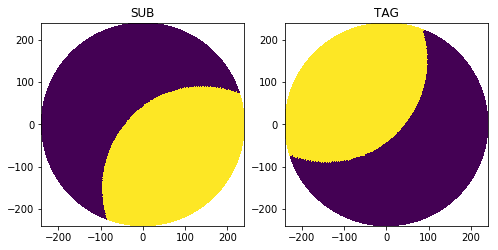

In [9]:
fig, (ax1,ax2) = pl.subplots(1,2, figsize=(8,4))

ax1,pm1 = wrl.vis.plot_ppi(overlap_1in2[0,:,:], ax=ax1)
ax1.set_title('SUB')
ax2,pm2 = wrl.vis.plot_ppi(overlap_2in1[0,:,:], ax=ax2)
ax2.set_title('TAG')

The yellow areas above show where one radar overlaps the other.

How many points are in the overlap?

In [10]:
xyz1to1[...,0][overlap_1in2].shape

(348100,)

### The matching part.

Now we want to find the intersections of the radar beams. To do this, we want to find the distances of the radar bins surrounding each bin.

A KDTree approach will be applied.

First, a tree is "planted". This sets the points at which the neighbors will be searched.

In [11]:
%%time
tree = spatial.KDTree(xyz1to1[overlap_1in2].reshape((-1,3)) )

Wall time: 1.3 s


`query` then looks for the nearest point and gives it index, as well as the distance.

In [12]:
%%time
dists, ix = tree.query(xyz_2to1[overlap_2in1].reshape((-1,3)))

Wall time: 1min 34s


Select indices at which the distances of the nearest points are below a certain threshold. In this case, the threshold is set at 250 meters.

In [13]:
ix2 = ix[dists < 250.]
ix1 = np.argwhere(dists < 250.)

Select the matched points - the nearest points within a certain distance in each of the overlapping areas.

We can get the polar coordinates of the matched points.

In [14]:
matched1_polar = sph1[overlap_1in2].reshape((-1,3))[ix2,:]
matched2_polar = sph2[overlap_2in1].reshape((-1,3))[ix1,:]

As an example, let's look at the intersection of the 0.5 elevation angles from both radars.

In [15]:
matched1_polar_0 = matched1_polar[np.ravel(matched1_polar[...,2]==0.5) & np.ravel(matched2_polar[...,2]==0.5)]
matched2_polar_0 = matched2_polar[np.ravel(matched1_polar[...,2]==0.5) & np.ravel(matched2_polar[...,2]==0.5)]

# This can be applied to other elevation angles as well
# matched1_polar_1 = matched1_polar[np.ravel(matched1_polar[...,2]==1.5) & np.ravel(matched2_polar[...,2]==1.5)]
# matched2_polar_1 = matched2_polar[np.ravel(matched1_polar[...,2]==1.5) & np.ravel(matched2_polar[...,2]==1.5)]

In [16]:
matched1_polar_0.shape

(1463, 3)

In [17]:
thetas1_0 = sph1[0,:,0,1]
rs1_0 = sph1[0,0,:,0]
thetas2_0 = sph2[0,:,0,1]
rs2_0 = sph2[0,0,:,0]

# thetas1_1 = sph1[1,:,0,1]
# rs1_1 = sph1[1,0,:,0]
# thetas2_1 = sph2[1,:,0,1]
# rs2_1 = sph2[1,0,:,0]

Now we need to get the polar indices of the matched points. 

In [18]:
rs_matched1_el0 = np.searchsorted(rs1_0,matched1_polar_0[...,0])
thetas_matched1_el0 = np.searchsorted(thetas1_0,matched1_polar_0[...,1])
rs_matched2_el0 = np.searchsorted(rs2_0,matched2_polar_0[...,0])
thetas_matched2_el0 = np.searchsorted(thetas2_0,matched2_polar_0[...,1])

# rs_matched1_el1 = np.searchsorted(rs1_1,matched1_polar_1[...,0])
# thetas_matched1_el1 = np.searchsorted(thetas1_1,matched1_polar_1[...,1])
# rs_matched2_el1 = np.searchsorted(rs2_1,matched2_polar_1[...,0])
# thetas_matched2_el1 = np.searchsorted(thetas2_1,matched2_polar_1[...,1])

To see how this looks like from the radar coverage perspective, let's create a blank sweep and "color" the selected matched bins.

In [19]:
sub_pts0 = np.zeros((360,240))
tag_pts0 = np.zeros((360,240))

sub_pts0[thetas_matched1_el0,rs_matched1_el0] = 1
tag_pts0[thetas_matched2_el0,rs_matched2_el0] = 1

Text(0.5, 1.0, 'TAG')

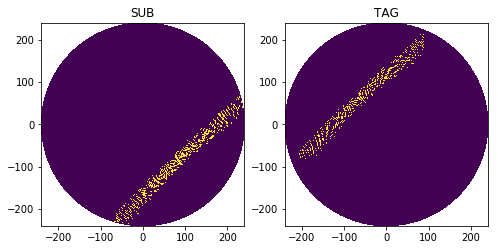

In [20]:
fig, (ax1,ax2) = pl.subplots(1,2, figsize=(8,4))

ax1,pm1 = wrl.vis.plot_ppi(sub_pts0, ax=ax1)
ax1.set_title('SUB')
ax2,pm2 = wrl.vis.plot_ppi(tag_pts0, ax=ax2)
ax2.set_title('TAG')

In [21]:
# Saving the objects:
with open('./output/GRGRmatchedpoints.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([rs_matched1_el0, thetas_matched1_el0, rs_matched2_el0, thetas_matched2_el0], f)

Looks good. Now we use these matched points in the next notebook to get the actual matched data.